In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import nibabel as nib
import scipy.stats
import matplotlib as mpl
from cmath import rect, phase
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter

In [3]:
def mean_angle(rad):
    return (phase(sum(rect(1, d) for d in rad)/float(len(rad))))

In [4]:
img = nib.load('panda_brain.nii')
data = img.get_data()

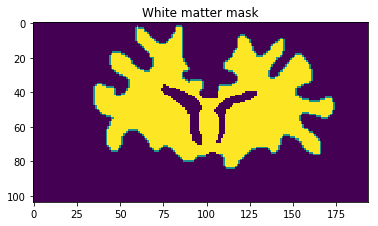

In [5]:
slice = data[:,3,:,0]

# XXX DUMMY SLICE

"""slice = np.zeros(slice.shape)
xx, yy = np.mgrid[:slice.shape[0], :slice.shape[1]]
x0, y0, radius = 15, 15, 10
circle = (xx - x0)**2 + (yy - y0)**2
slice = circle <= radius**2
slice = 255 * slice.astype(np.uint8)"""


plt.figure()
plt.imshow(slice.T, interpolation='none')
plt.title("White matter mask")

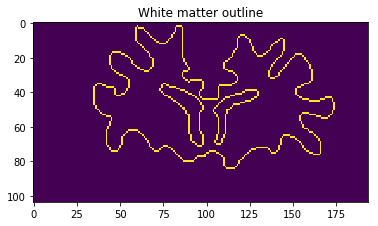

In [7]:
border  = np.zeros_like(slice)
for (i, j), val in np.ndenumerate(slice):
    if i > 0 and i < slice.shape[0] - 1 and j > 0 and j < slice.shape[1] - 1:
        if val > 0:
            if slice[i - 1, j] == 0 \
             or slice[i + 1, j] == 0 \
                or slice[i, j - 1] == 0 \
                or slice[i, j + 1] == 0:
                    border[i, j] = 1


plt.figure()
plt.title("White matter outline")
plt.imshow(border.T, interpolation='none')
                

In [8]:
idx = np.where(border)
n_idx = idx[0].size

In [9]:
#%debug
n_particles = 50
max_particle_steps = 1000
density_map = np.zeros_like(slice, dtype=np.float)
direction_map = np.zeros_like(slice, dtype=np.complex)   # N.B. direction is stored as complex numbers (vector representation in the complex plane) to facilitate averaging

trajectories = []

for particle_idx in range(n_particles):
    if (particle_idx + 1) % 1000 == 0:
        print("Progress: " + str(particle_idx + 1) + " out of " + str(n_particles))
    start_voxel_idx = np.random.randint(n_idx)
    start_voxel = np.array([idx[0][start_voxel_idx], idx[1][start_voxel_idx]], dtype=np.int)
    initial_direction_ang = scipy.stats.uniform(0., 2 * np.pi).rvs()
    initial_direction_vector = np.array([np.cos(initial_direction_ang), np.sin(initial_direction_ang)])

    #
    #   simulate particle trajectory
    #

    voxel_scale = 1.   # scale factor between "voxel space" and "particle space"

    trajectory_x = []
    trajectory_y = []
    trajectory_voxel_x = []
    trajectory_voxel_y = []

    x0, y0, x1, y1 = 0., 0., initial_direction_vector[0], initial_direction_vector[1]
    dt = .1
    m = .1 # particle mass
    lmbd = .1 # damping parameter
    zeta = 10.  # drift strength
    noise_ampl = .1
    for i in range(max_particle_steps):

        voxel_x = np.round(voxel_scale * x0).astype(np.int) + start_voxel[0]
        voxel_y = np.round(voxel_scale * y0).astype(np.int) + start_voxel[1]
        
        
        #
        #  termination condition: too many steps or particle exited WM mask
        #
        
        if voxel_x < 0 or voxel_x >= slice.shape[0] \
         or voxel_y < 0 or voxel_y >= slice.shape[1] \
         or slice[voxel_x, voxel_y] == 0:
            break

            
        #
        #  logging
        #

        trajectory_x.append(x0)
        trajectory_y.append(y0)

        trajectory_voxel_x.append(voxel_x)
        trajectory_voxel_y.append(voxel_y)

            
        #
        #  update state
        #
        
        grad = np.gradient(gaussian_filter(density_map, sigma=2))
        noise_x = noise_ampl * scipy.stats.norm(0., 1.).rvs()   # 
        noise_y = noise_ampl * scipy.stats.norm(0., 1.).rvs()
        dx0 = x1
        dy0 = y1
        dx1 = (- lmbd * x1 + noise_x + zeta * grad[0][voxel_x, voxel_y]) / m
        dy1 = (- lmbd * y1 + noise_y + zeta * grad[1][voxel_x, voxel_y]) / m
    
        x0 += dt * dx0
        y0 += dt * dy0
        x1 += dt * dx1
        y1 += dt * dy1

    trajectories.append((trajectory_voxel_x, trajectory_voxel_y))
#     trajectory_voxel_x = np.round(voxel_scale * np.array(trajectory_x)).astype(np.int) + start_voxel[0]
#     trajectory_voxel_y = np.round(voxel_scale * np.array(trajectory_y)).astype(np.int) + start_voxel[1]

    if i > 1 and len(np.unique(trajectory_voxel_x)) > 1 and len(np.unique(trajectory_voxel_y)) > 1:
        for i in range(1, len(trajectory_voxel_x)):
            direction_vec = np.array([trajectory_x[i] - trajectory_x[i-1], trajectory_y[i] - trajectory_y[i-1]])
            density_map[trajectory_voxel_x[i], trajectory_voxel_y[i]] += 1.

            if np.linalg.norm(direction_vec) > 0.:
                direction_vec /= np.linalg.norm(direction_vec)
                direction_ang = np.arctan2(direction_vec[1], direction_vec[0])
                if direction_ang < 0.:
                    direction_ang += np.pi
                direction_map[trajectory_voxel_x[i], trajectory_voxel_y[i]] += rect(1, direction_ang)
        
#
#   convert direction back from complex format to angle
#

direction_map_ang = np.empty_like(slice, dtype=np.float)
for (i, j), _ in np.ndenumerate(direction_map):
    direction_map_ang[i, j] = np.abs(np.pi-phase(direction_map[i, j]))
    # density /= float(n_particles)

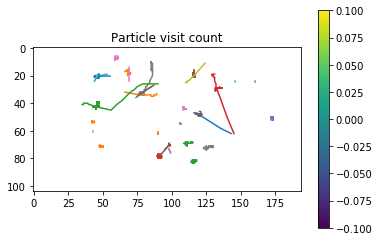

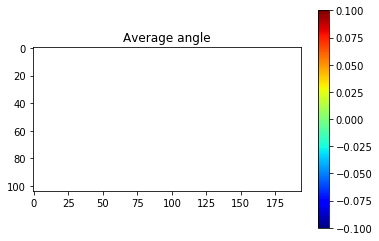

In [10]:
cmap = plt.cm.jet
cmap.set_bad('w', 1.)

plt.figure()
masked_array = np.ma.array(density_map, mask=255 - slice)
plt.imshow(masked_array.T, interpolation="none")
plt.title("Particle visit count")
for particle_idx in range(n_particles):
    plt.plot(trajectories[particle_idx][0], trajectories[particle_idx][1])
plt.colorbar()

#cmap = plt.cm.hsv
#cmap.set_bad('w', 1.)
#norm = mpl.colors.Normalize(vmin=0., vmax=np.pi)
norm = None

plt.figure()
masked_array = np.ma.array(direction_map_ang, mask=255 - slice)
plt.imshow(masked_array.T, interpolation='none', cmap=cmap, norm=norm)
plt.title("Average angle")
plt.colorbar()


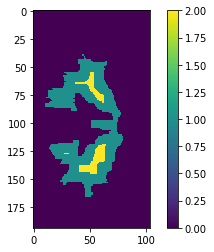

In [11]:
plt.imshow(gaussian_filter(slice, sigma=2), interpolation="none")
plt.colorbar()

In [12]:
img = gaussian_filter(slice, sigma=2)

gradx, grady = np.gradient(img.astype(np.float))
print("min = " + str(np.amin(img)) + ", max = " + str(np.amax(img)))
print("gradx min = " + str(np.amin(gradx)) + ", max = " + str(np.amax(gradx)))
#X, Y = np.meshgrid(np.linspace(0, slice.shape[0], slice.shape[0]), np.linspace(0, slice.shape[1], slice.shape[1]))
#plt.quiver(Y.T, X.T, gradx, grady, pivot="mid")
# plt.imshow(grady)

min = 0, max = 2
gradx min = -0.5, max = 0.5


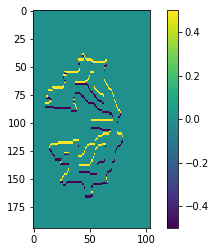

In [13]:
plt.imshow(gradx, interpolation="none")
plt.colorbar()
#np.unique(np.abs(gradx))

In [14]:
np.gradient(gaussian_filter(slice, sigma=2))[0].shape

(194, 104)